In [1]:
import pandas as pd
from top2vec import Top2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_wrangling.load_data import load_political_quotes

from textblob import TextBlob
from src.sentiment_analysis import get_subjectivity, get_polarity, get_sentiment

from scripts.rs3_helper import *

# Finding the most popular politicians by party

## Load all quotes

In [2]:
"""
all_political_quotes = []
countries = ['France', 'Italy', 'Germany', 'Spain', 'Poland']
for batch in load_political_quotes(country=countries, chunksize=20000, year=[2015, 2016]):
    all_political_quotes.append(batch)
    
all_political_quotes = pd.concat(all_political_quotes, axis=0, ignore_index=True)
"""

"\nall_political_quotes = []\ncountries = ['France', 'Italy', 'Germany', 'Spain', 'Poland']\nfor batch in load_political_quotes(country=countries, chunksize=20000, year=[2015, 2016]):\n    all_political_quotes.append(batch)\n    \nall_political_quotes = pd.concat(all_political_quotes, axis=0, ignore_index=True)\n"

In [3]:
"""
all_political_quotes = all_political_quotes[['quotation', 'speaker', 'country', 'political_alignment', 'date', 'political_party']]
all_political_quotes['date'] = pd.to_datetime(all_political_quotes['date'])
"""

"\nall_political_quotes = all_political_quotes[['quotation', 'speaker', 'country', 'political_alignment', 'date', 'political_party']]\nall_political_quotes['date'] = pd.to_datetime(all_political_quotes['date'])\n"

In [4]:
path_to_topics_data = 'data/topics/'

topics = ['covid', 'terrorism', 'immigration', 'europe', 'discrimination', 'russia', 'israeli_palestinian', 'climate_change']

quotes = dict()

for topic in topics:
    quotes[topic] = pd.read_csv(path_to_topics_data + topic + '_quotes')

In [5]:
all_political_quotes = pd.concat(quotes.values())

These are the partys to be examined.

In [6]:
right_partys = {'Italy':'Lega Nord', 'Germany':'Alternative for Germany', 'France':'National Rally', 'Poland':'Law and Justice', 'Spain':'People\'s Party'}

In order to compare the prominent right-wing politicians, we look at the most quoted politicians of each party and choose the first one, since he/she is the publicly most present member of his/her party.

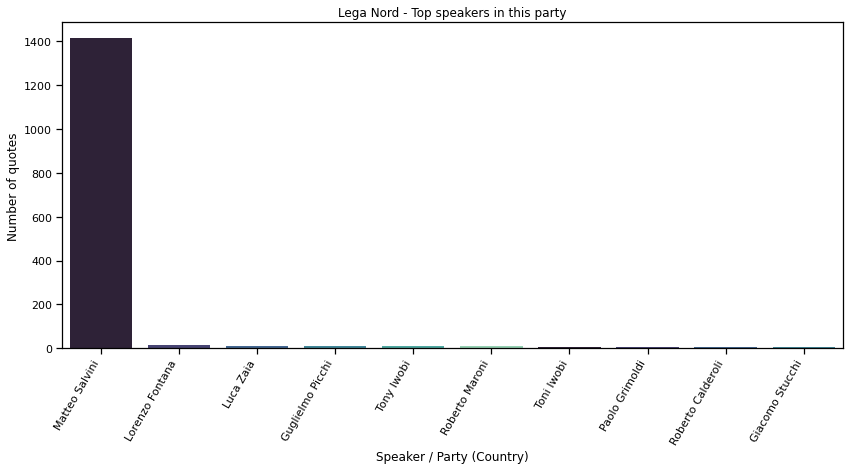

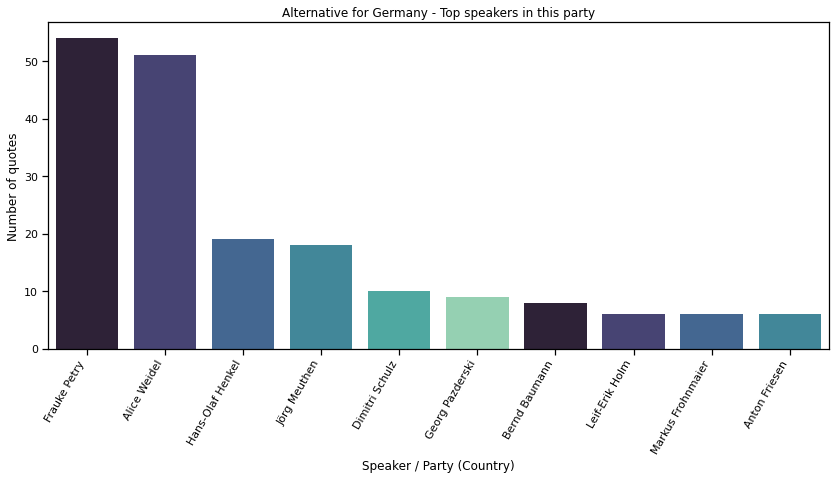

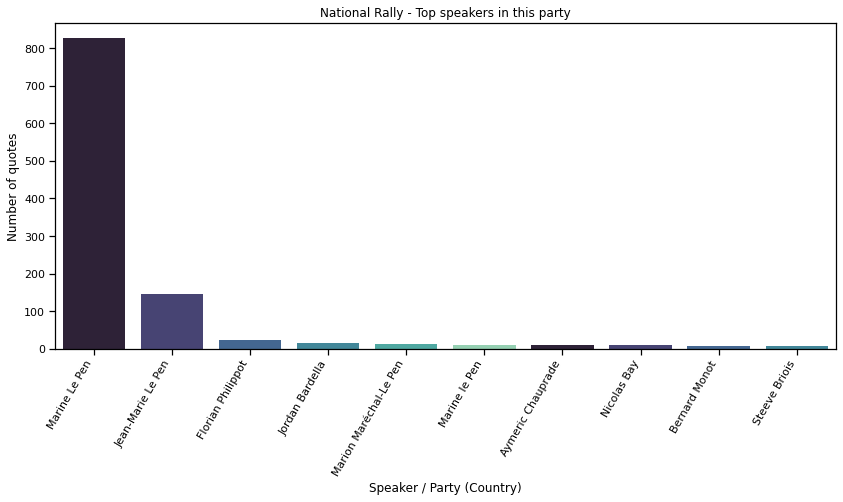

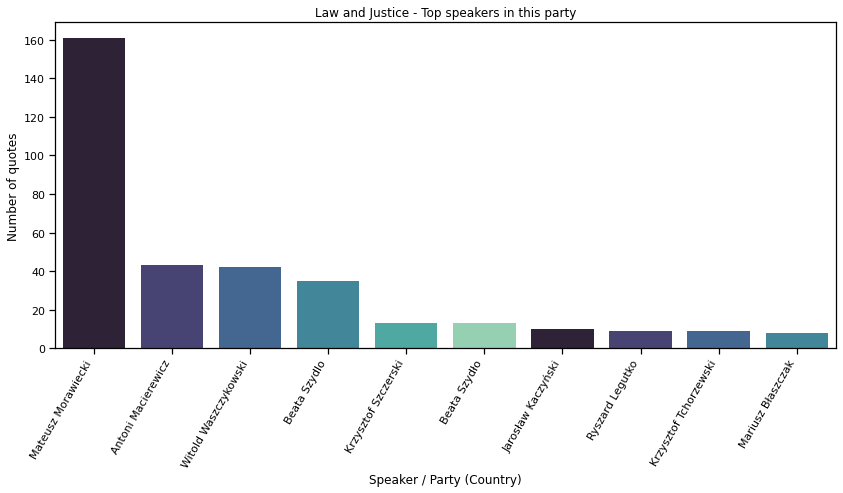

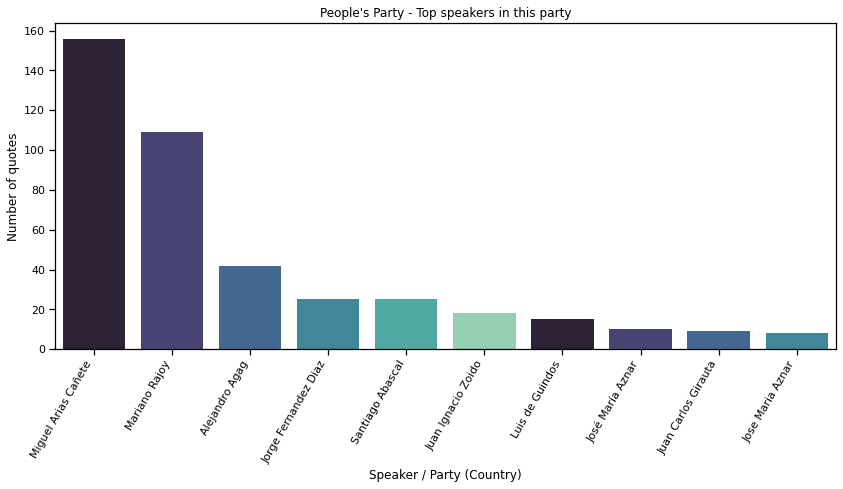

In [7]:
top_speaker_by_party = dict()

for party in right_partys.values():
    party_quotes = all_political_quotes.query('political_party == "' + party + '"')
    top_speaker_by_party[party] = show_top_k_speakers_party(party, party_quotes)

... and create a list of politicians we want to examine.

In [8]:
for party in right_partys.values():
    top_speaker_by_party[party] =  top_speaker_by_party[party]['speaker'].iloc[0:1].tolist()

In [9]:
top_speaker_by_party

{'Lega Nord': ['Matteo Salvini'],
 'Alternative for Germany': ['Frauke Petry'],
 'National Rally': ['Marine Le Pen'],
 'Law and Justice': ['Mateusz Morawiecki'],
 "People's Party": ['Miguel Arias Cañete']}

# Load quotes per topic

In [10]:
path_to_topics_data = 'data/topics/'

topics = ['covid', 'terrorism', 'immigration', 'europe', 'discrimination', 'russia', 'israeli_palestinian', 'climate_change']

quotes = dict()

for topic in topics:
    quotes[topic] = pd.read_csv(path_to_topics_data + topic + '_quotes')

# Add sentiment values per quote

Add sentiment values using TextBlob:

In [11]:
"""
for topic in topics:
    quotes[topic]['subjectivity'] = quotes[topic]['quotation'].apply(get_subjectivity)
    quotes[topic]['polarity'] = quotes[topic]['quotation'].apply(get_polarity)
    quotes[topic]['sentiment'] = quotes[topic]['polarity'].apply(get_sentiment)
"""

"\nfor topic in topics:\n    quotes[topic]['subjectivity'] = quotes[topic]['quotation'].apply(get_subjectivity)\n    quotes[topic]['polarity'] = quotes[topic]['quotation'].apply(get_polarity)\n    quotes[topic]['sentiment'] = quotes[topic]['polarity'].apply(get_sentiment)\n"

Add sentiment values using nltk VADER:

In [12]:

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
for topic in topics:
    quotes[topic]['polarity'] = quotes[topic]['quotation'].apply(lambda x: sia.polarity_scores(x)['compound'])#


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Construct Dataframe with most popular speakers:

In [13]:
popular_politicians = dict()
for key in top_speaker_by_party.keys():
    popular_politicians[top_speaker_by_party[key][0]] = key
    #popular_politicians[top_speaker_by_party[key][1]] = key
popular_politicians = pd.DataFrame.from_dict(popular_politicians, orient='index', columns=['political_party']).reset_index().rename(columns={'index':'speaker'})

In [14]:
popular_politicians

speaker          political_party
0       Matteo Salvini                Lega Nord
1         Frauke Petry  Alternative for Germany
2        Marine Le Pen           National Rally
3   Mateusz Morawiecki          Law and Justice
4  Miguel Arias Cañete           People's Party

And calculate the average polarity of all quotes per topic for each politician. This should be a proxy for the opinion of each politician on a topic.

In [15]:
def calculate_avg_polarity_per_speaker(politician_row, quotes):
    speaker = politician_row['speaker']
    
    return quotes.query('speaker == @speaker')['polarity'].mean()

In [16]:
for topic in topics:
    popular_politicians[str(topic) + '_avg_polarity'] = popular_politicians.apply(lambda row: calculate_avg_polarity_per_speaker(row, quotes[topic]), axis=1)

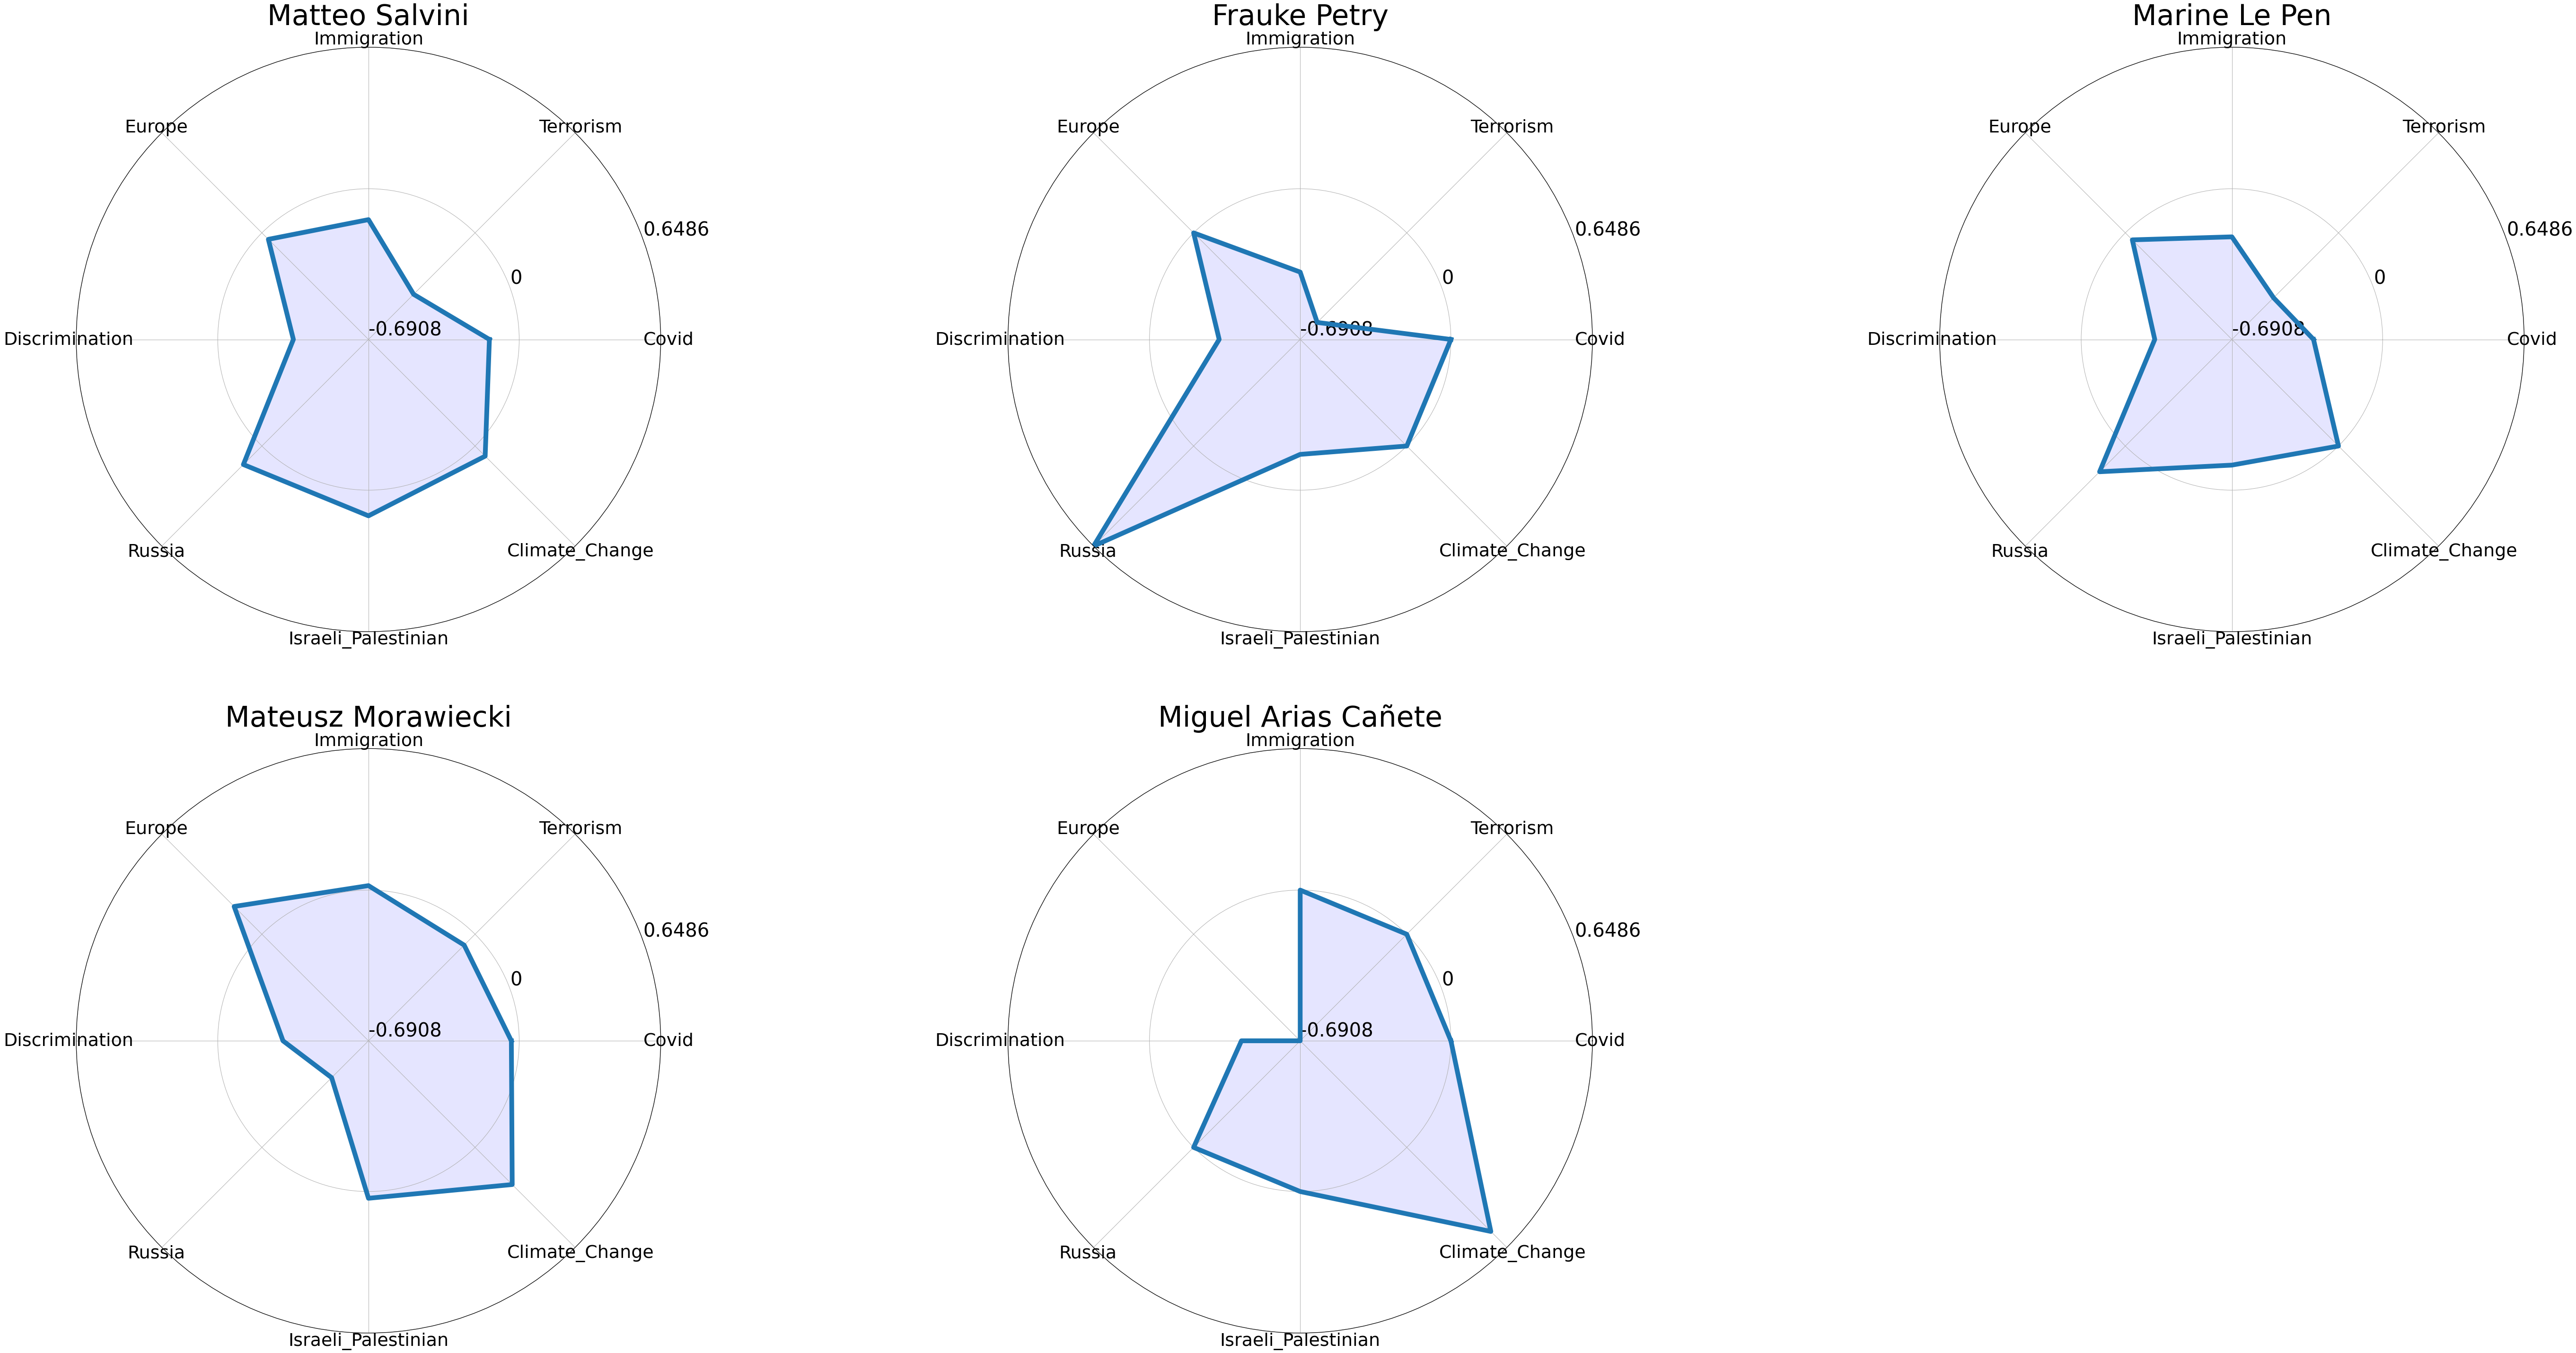

In [17]:
show_all_polarity_radar(popular_politicians, topics)

#### Interpretation: differences between right-wing politicians from different european countries

1. Miguel Arias Cañete

    - was European Commissioner for Energy and Climate Action => highly postive on climate change makes sense  
    - no quotes on most topics and one on europe and one related to discrimination (see diostributions per topics below) => doesnt tell us anything  
      => not relevant, alternative politicians: There is no right-wing party in spain, only some very small far-right partys which almost don't have any quotes at all  
    - other politicians which were quoted relativly often are prime ministers and entreprenuers who were in politics for some time in the past.  
      => spain not relevant in this analysis  

2. Frauke Petry
    - unfortunately for Frauke Petry the quotes are concentrated on the topics of immigration, terrorism and discrimination and for the other topics we have almost no quotes (see distributions below). Although this focus on the immigration topic could make sense, since during her time as the leader of her party this topic was the most important topic of her party, following the "immigration crisis" in 2015, and is the reason for the partys success in Germany.
        
2.  Difference between Mateusz Morawiecki and the other right-wing polticians: (Mateusz Morawiecki the polish prime minister and the only right-wing poltician actually being in government in the countries we considered)

    - While the other right-wing politicians are quoted in general more positivly on Russia, Mateusz Morawiecki's quotes on russia are very negative. Poland due to its proximity to russia, its history and the events in Ukrain feels threatened. ("Once Nord Stream 2 is built, Putin can do with Ukraine whatever he wants, and then we have potentially his army on the eastern border of the EU,")

    - Mateusz Morawiecki is, according to the average polarity score, more positive on the topic EU than the other right-wings. If we look into the quotes, they are mostly Brexit related and mostly in favour of keeping Britian in the EU ("So let's make sure we hook London to the continent."). While when looking into the quotes of e.g. Matteo Salvini, we get sentences like: "The enemy is no longer the south and Rome but external enemies, in particular, the European Union and immigrants".
    
3. Matteo Salvini and Mateusz Morawiecki are postive on israeli_palestinian topic, while Marine Le Pen and Frauke Petri are negative.
    - In this case the quotes are unclear. For Marine Le Pen e.g., they are only loosly related to the topic via mentioning terms like islam, Israel or the middle east. While for Matteo Salvini e.g. the quotes are realted to the topic, but it is still difficult even as human what a positive or negative quote would be. Is a quote in favour of Israel a positive quote? So the topic is not well formulated in this case.
    
4. Terrorism is generally talked about in a more negative language (negative score). The quotes are mostly related to terror attacks and ISIS. So it does make sense that most european politian will generally talk negativly about terrorism.

5. Also immigration is a generally negativly talked about topic, as one would expect from right-wing politicians. The exception seems to be the polish prim minister Mateusz Morawiecki. But if we look at the quotes, the positive quotes are mostly talking in a positive way about polands/european immigration policy (wishes).("An ever greater number of countries is becoming convinced that the best solution is not to forcibly relocate refugees [ within the EU ] nor to impose fines on countries that refuse to accept them, but to expand our collaboration to help those countries which are the source of the refugee flows to Europe, as well as to harden the external borders of the European Union,") This also show that the avg score positivity score can also be flawed, especially if there are bnot many quotes or it can be misleading if the general language is positve, but the actual meaning is opposing a position.

6. Covid would be an interesting topic, but unfortunately, since it only appeard at the end of the examined time period, there are almost no quotes by right-wing polticians. During the beginning of Covid, the oppinion of a non-government european politician from a smaller party was probably not important enough for the "New York Times".

In [18]:
quotes['russia'].iloc[2595]['quotation']

'Once Nord Stream 2 is built, Putin can do with Ukraine whatever he wants, and then we have potentially his army on the eastern border of the EU,'

In [19]:
quotes['immigration'].query('speaker == "Mateusz Morawiecki"')

Unnamed: 0                                          quotation  \
3140      232117  We are taking money away from mafias and tax c...   
3512      262963  The EU's immigration policy is not working... ...   
4187      301071  we will not be allowing migrants from the Midd...   
4266      305449  Our sovereign principles on securing our borde...   
4315      308558  An ever greater number of countries is becomin...   
4505      319645  Poland opposes the mandatory quota system for ...   
4598      325110  We will not accept refugees, migrants from the...   
4688      331014  We will not be allowing migrants from the Midd...   
4709      332228  We will not accept migrants from the Middle Ea...   
4818      338379  NO for compulsory sharing of migrants and unan...   
6079      450829  In the current situation, however, we cannot a...   

                 speaker country political_alignment                 date  \
3140  Mateusz Morawiecki  Poland          right-wing  2017-12-08 18:11:50   
3512  Mateusz Morawiecki  Poland          right-wing  2018-01-03 16:55:00   
4187  Mateusz Morawiecki  Poland          right-wing  2018-11-13 03:24:41   
4266  Mateusz Morawiecki  Poland          right-wing  2018-11-12 10:51:21   
4315  Mateusz Morawiecki  Poland          right-wing  2018-06-29 20:46:16   
4505  Mateusz Morawiecki  Poland          right-wing  2018-01-02 00:00:00   
4598  Mateusz Morawiecki  Poland          right-wing  2018-01-03 07:11:33   
4688  Mateusz Morawiecki  Poland          right-wing  2018-08-17 09:08:21   
4709  Mateusz Morawiecki  Poland          right-wing  2018-07-04 05:12:12   
4818  Mateusz Morawiecki  Poland          right-wing  2018-06-29 13:38:00   
6079  Mateusz Morawiecki  Poland          right-wing  2020-03-17 04:30:00   

      political_party  polarity  
3140  Law and Justice   -0.3182  
3512  Law and Justice   -0.5106  
4187  Law and Justice    0.0000  
4266  Law and Justice    0.3182  
4315  Law and Justice    0.9412  
4505  Law and Justice    0.0772  
4598  Law and Justice   -0.2924  
4688  Law and Justice    0.0000  
4709  Law and Justice   -0.2924  
4818  Law and Justice    0.4708  
6079  Law and Justice   -0.1695

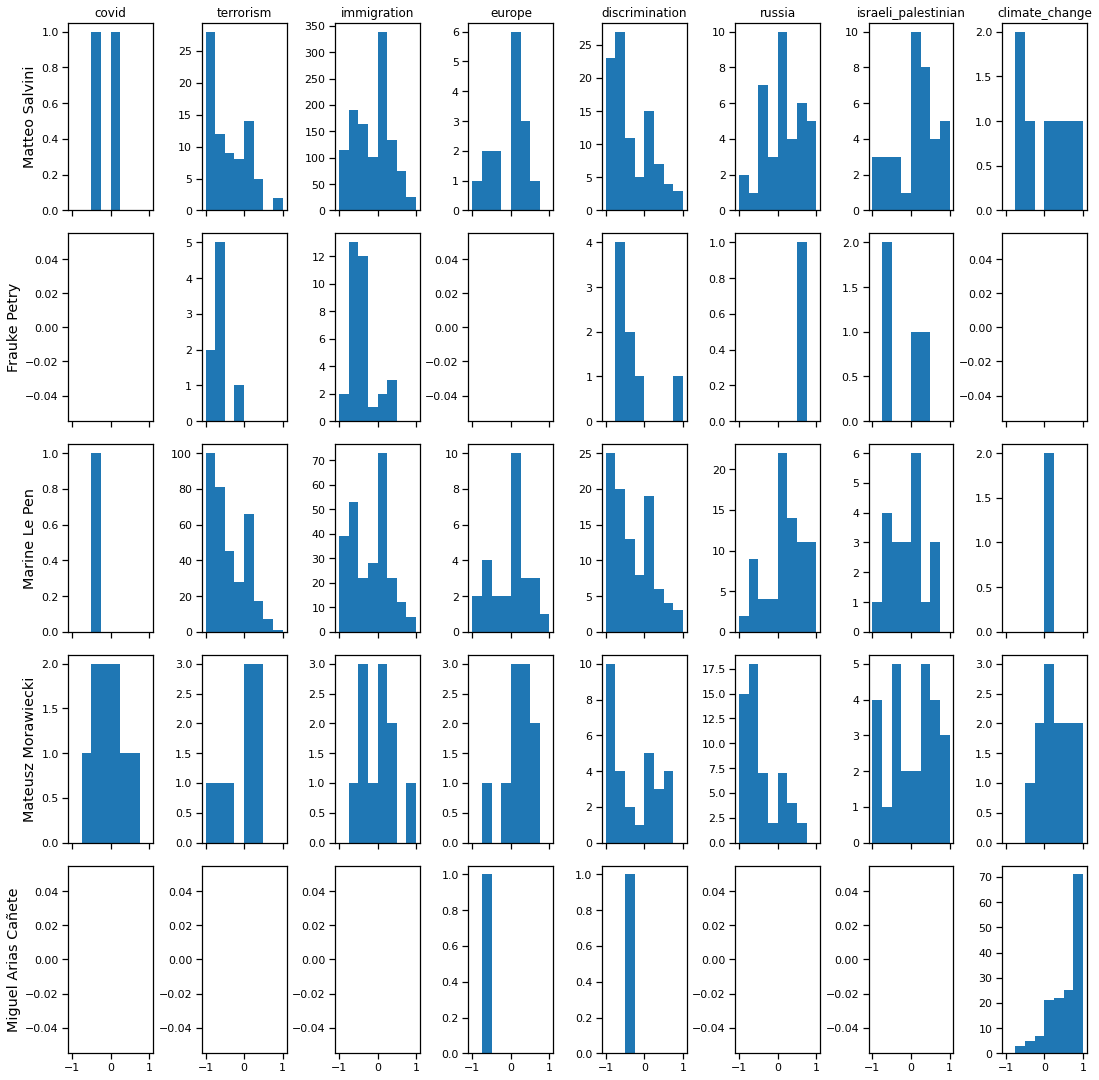

In [20]:
show_distr_speaker_topic(popular_politicians, topics, quotes_by_topic = quotes)

Finally, we look at the current heads of government of each country in order to compare them with the most quoted right wing politicians. Except for Poland, there the government is lead by the right-wing party.

In [21]:
heads_of_gov = {
    'speaker':['Matteo Renzi', 'Angela Merkel', 'Emmanuel Macron'], #Matteo Renzi Paolo Gentiloni
    'political_party':['Democratic Party', 'Christian Democratic Union', 'La République En Marche']
}
heads_of_gov = pd.DataFrame(heads_of_gov)

In [22]:
heads_of_gov

speaker             political_party
0     Matteo Renzi            Democratic Party
1    Angela Merkel  Christian Democratic Union
2  Emmanuel Macron     La République En Marche

In [23]:
for topic in topics:
    heads_of_gov[str(topic) + '_avg_polarity'] = heads_of_gov.apply(lambda row: calculate_avg_polarity_per_speaker(row, quotes[topic]), axis=1)

In [24]:
right_wings_and_gov = heads_of_gov.append(popular_politicians.query('speaker != "Mateusz Morawiecki"').query('speaker != "Miguel Arias Cañete"'), ignore_index=True)
right_wings_and_gov

speaker             political_party  covid_avg_polarity  \
0     Matteo Renzi            Democratic Party            0.381800   
1    Angela Merkel  Christian Democratic Union           -0.051979   
2  Emmanuel Macron     La République En Marche           -0.058474   
3   Matteo Salvini                   Lega Nord           -0.136600   
4     Frauke Petry     Alternative for Germany                 NaN   
5    Marine Le Pen              National Rally           -0.316700   

   terrorism_avg_polarity  immigration_avg_polarity  europe_avg_polarity  \
0               -0.340264                 -0.185248            -0.215911   
1               -0.419350                 -0.054611             0.101321   
2               -0.406522                 -0.092193             0.131517   
3               -0.398185                 -0.141640            -0.041887   
4               -0.580475                 -0.381997                  NaN   
5               -0.420807                 -0.220537            -0.045285   

   discrimination_avg_polarity  russia_avg_polarity  \
0                    -0.525092             0.118983   
1                    -0.222372             0.060315   
2                    -0.218754             0.104715   
3                    -0.346596             0.119963   
4                    -0.319487             0.648600   
5                    -0.337203             0.166771   

   israeli_palestinian_avg_polarity  climate_change_avg_polarity  
0                          0.149933                     0.123475  
1                          0.100011                     0.212548  
2                          0.156497                     0.101173  
3                          0.117676                     0.065557  
4                         -0.164000                          NaN  
5                         -0.114829                     0.000000

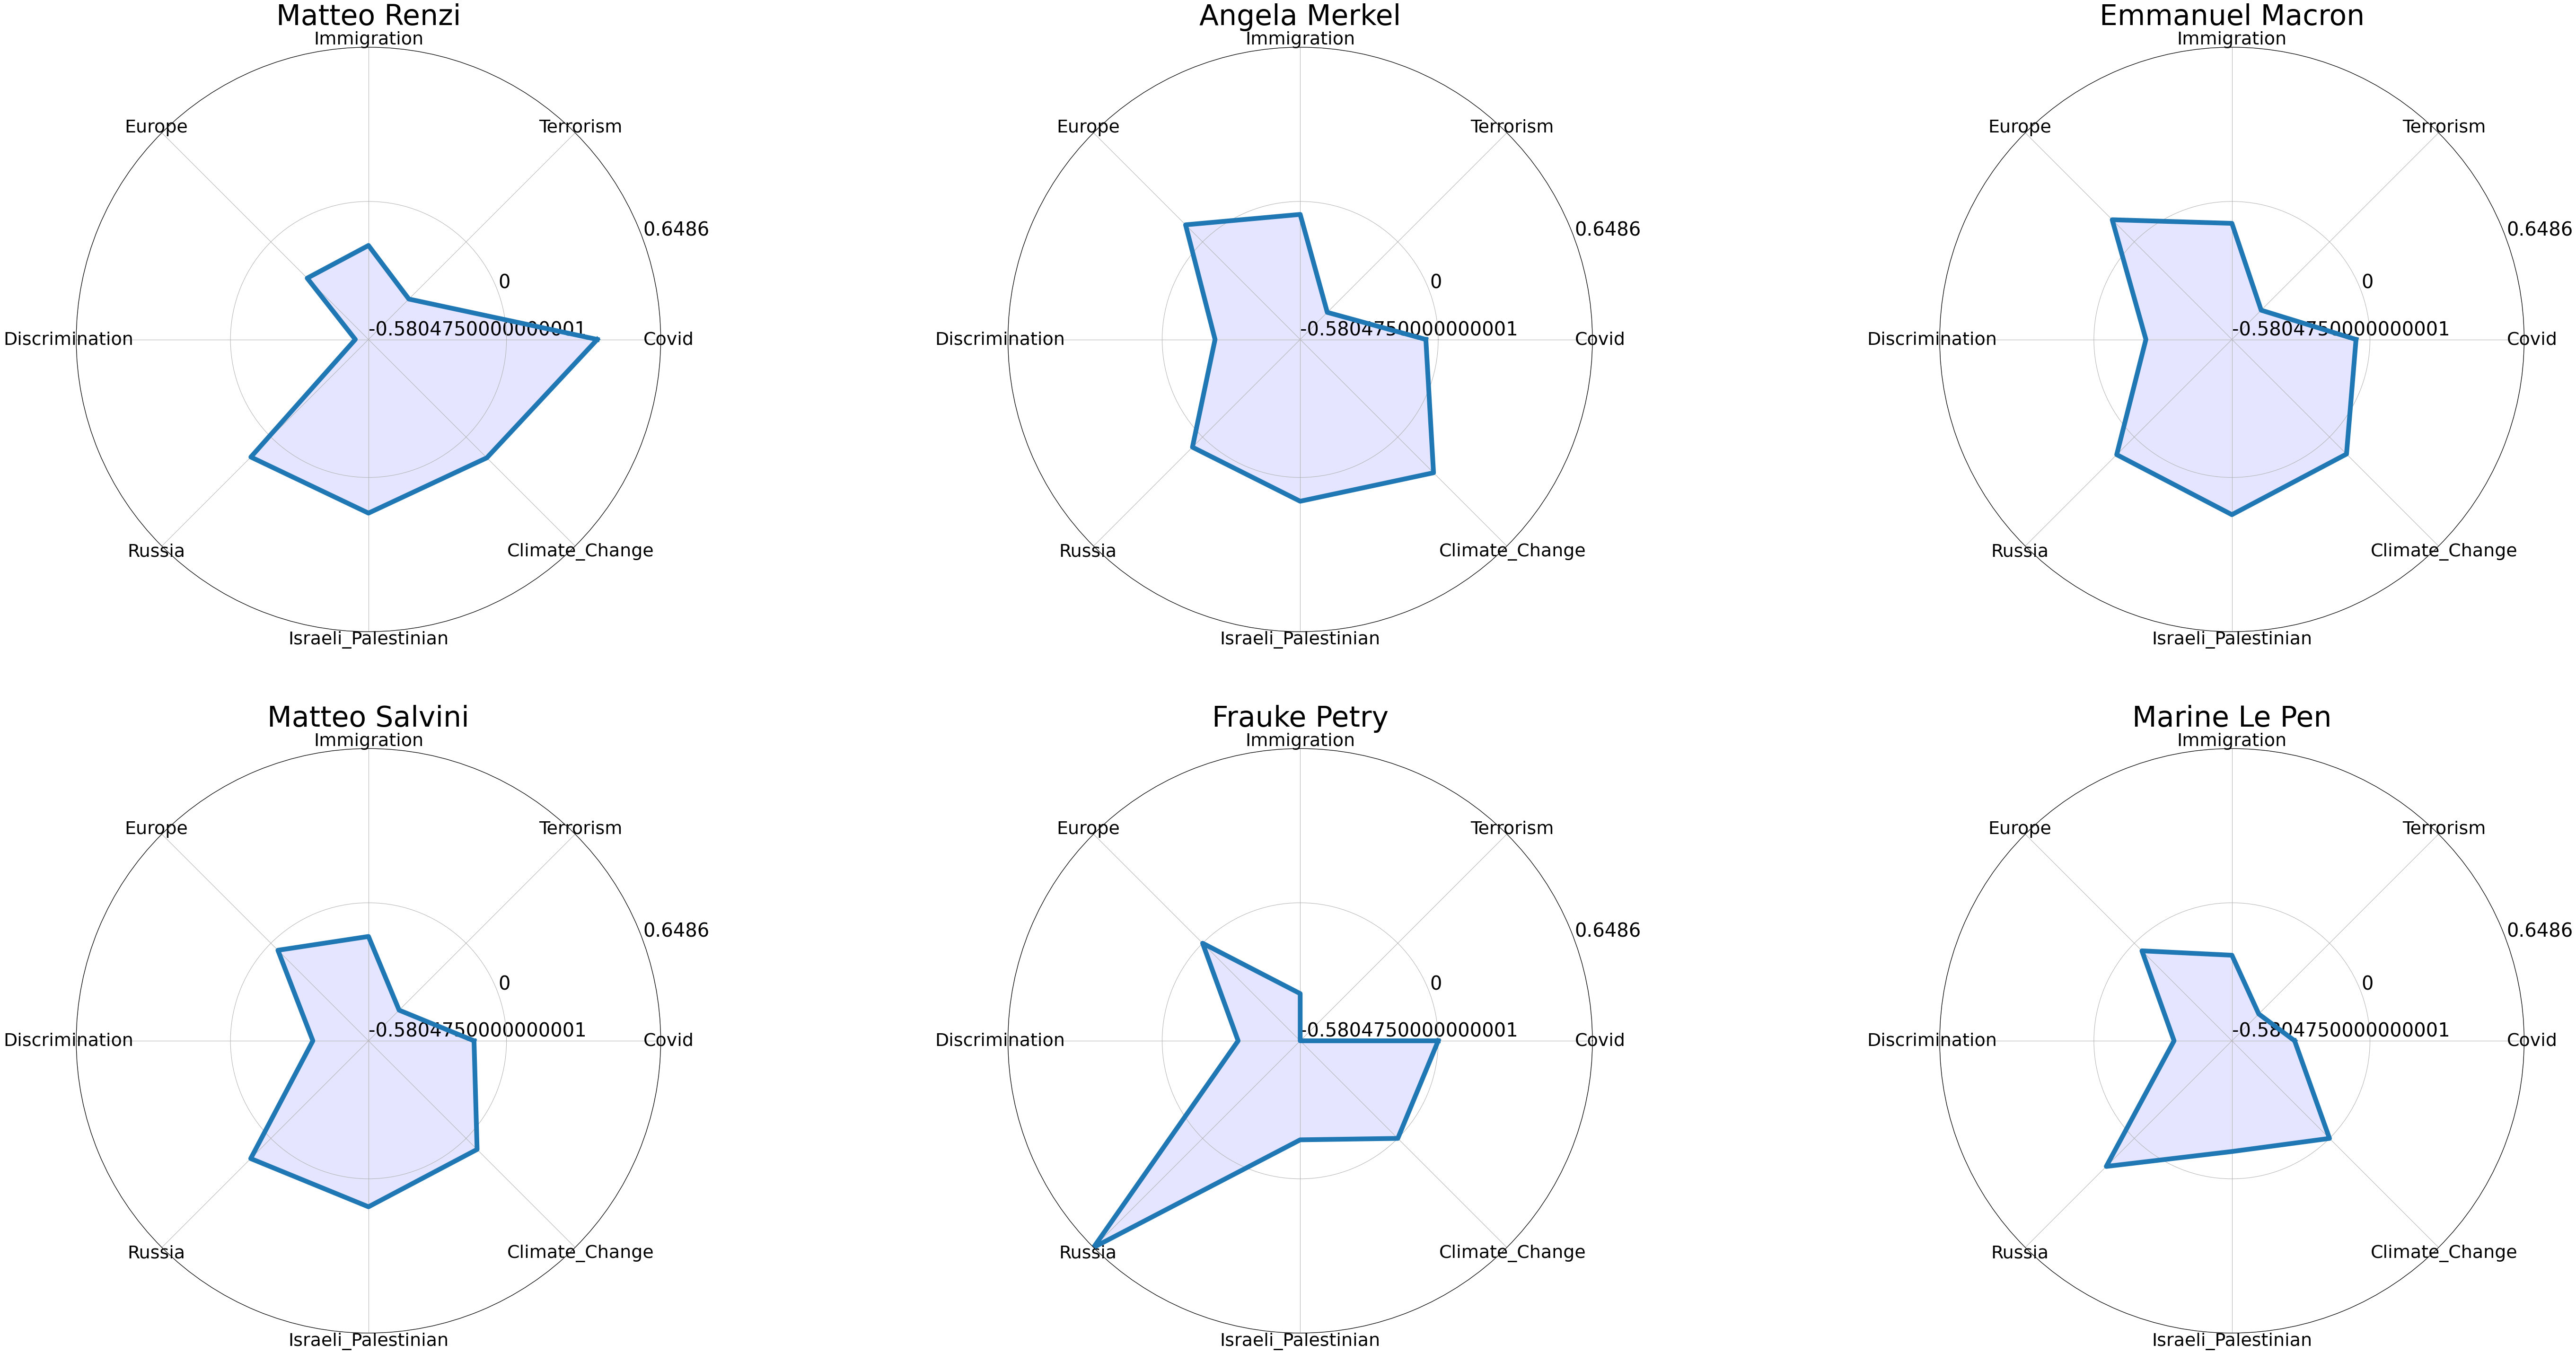

In [25]:
show_all_polarity_radar(right_wings_and_gov, topics, grid=(2,3))

In [26]:
pd.set_option('display.max_colwidth', -1) 

C:\Users\Andi\AppData\Local\Temp/ipykernel_64312/275896945.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


------------------------------------------------------------------------------------------------------

In [27]:
quotes['russia'].query('speaker == "Matteo Renzi"')

Unnamed: 0  \
62    6491         
274   29655        
347   37902        
365   38848        
578   61983        
604   64526        
620   66737        
636   68369        
643   69354        
650   69932        
2429  310161       
3103  393346       

                                                                                                                                                                  quotation  \
62    I am confident that the Russian Federation may play a decisive role in resolving the problem,                                                                           
274   part of the world also needs Russia                                                                                                                                     
347   Absolutely no to more sanctions.                                                                                                                                        
365   needs Russia's help on the Libyan question.                                                                                                                             
578   The Prime Minister spoke to Prime Minister Renzi of Italy this afternoon about the situation in Ukraine,                                                                
604   We will continue to work together to implement the Minsk accord and doing all we can to return to peace with the respect of the integrity and sovereignty of Ukraine,   
620   EU & USA share with Moscow need to fight Daesh but we need a solution with strategic scope..                                                                            
636   I believe that it is important to involve Russia in this coalition, but it would be a mistake to leave only Russia to lead this strategy,                               
643   First of all there is the question of European Union relations with Russia in the context of the Ukraine crisis,                                                        
650   We must preserve Ukraine's sovereignty, we must preserve Ukraine's identity and borders. And for this reason it's correct to have the sanctions against Putin,          
2429  There was a referendum, and 90 percent of the people voted for the return of Crimea to the Russian Federation,                                                          
3103  In your own interest, finally clarify your relations with the Russians.                                                                                                 

           speaker country political_alignment                 date  \
62    Matteo Renzi  Italy   centre-left         2015-03-06 08:57:28   
274   Matteo Renzi  Italy   centre-left         2015-12-30 10:04:24   
347   Matteo Renzi  Italy   centre-left         2015-01-21 00:44:40   
365   Matteo Renzi  Italy   centre-left         2015-06-11 08:49:06   
578   Matteo Renzi  Italy   centre-left         2015-03-02 00:33:00   
604   Matteo Renzi  Italy   centre-left         2015-03-04 14:12:04   
620   Matteo Renzi  Italy   centre-left         2015-12-10 17:29:03   
636   Matteo Renzi  Italy   centre-left         2015-10-16 08:45:03   
643   Matteo Renzi  Italy   centre-left         2015-03-05 13:52:10   
650   Matteo Renzi  Italy   centre-left         2015-09-29 05:38:47   
2429  Matteo Renzi  Italy   centre-left         2018-07-20 00:00:00   
3103  Matteo Renzi  Italy   centre-left         2019-08-22 05:00:00   

       political_party  polarity  
62    Democratic Party  0.7506    
274   Democratic Party  0.0000    
347   Democratic Party -0.3597    
365   Democratic Party  0.4019    
578   Democratic Party  0.0000    
604   Democratic Party  0.8481    
620   Democratic Party  0.4118    
636   Democratic Party -0.4588    
643   Democratic Party -0.6249    
650   Democratic Party  0.0000    
2429  Democratic Party  0.0000    
3103  Democratic Party  0.4588

#### Interpretation: Governement vs Right-wing
In all considered countrys right-wing politicians talk more negativly on immigration than the polticians in government positions in the same country.


1.Le Pen & Petry closer to Russia:  
Marine Le Pen and Frauke Petry went to european right-wing meetings hosted by Russia and Le Pen even got funding for her party from a bank close to the russian governemnt.
- https://www.dw.com/en/head-of-the-afd-frauke-petry-meets-with-russian-officials-in-moscow/a-37643188
- https://www.washingtonpost.com/world/national-security/a-russian-bank-gave-marine-le-pens-party-a-loan-then-weird-things-began-happening/2018/12/27/960c7906-d320-11e8-a275-81c671a50422_story.html

Italian, germanheads of state quotes seem very similar except maybe on climate change.

----------------------------------------------------------------------

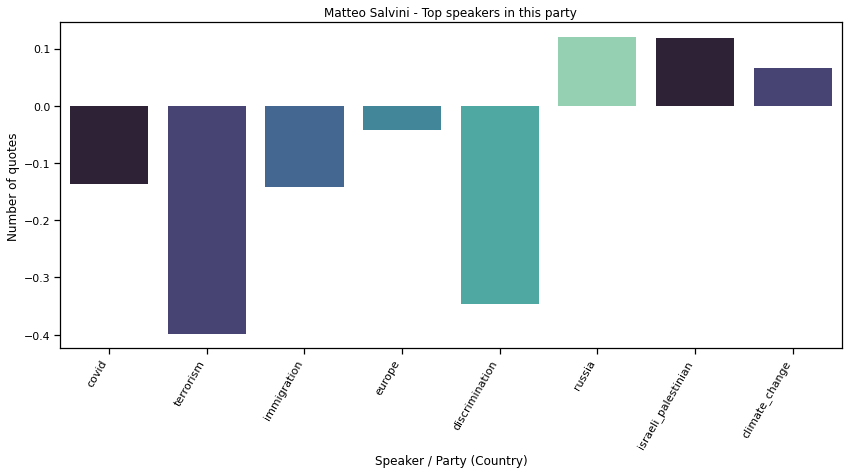

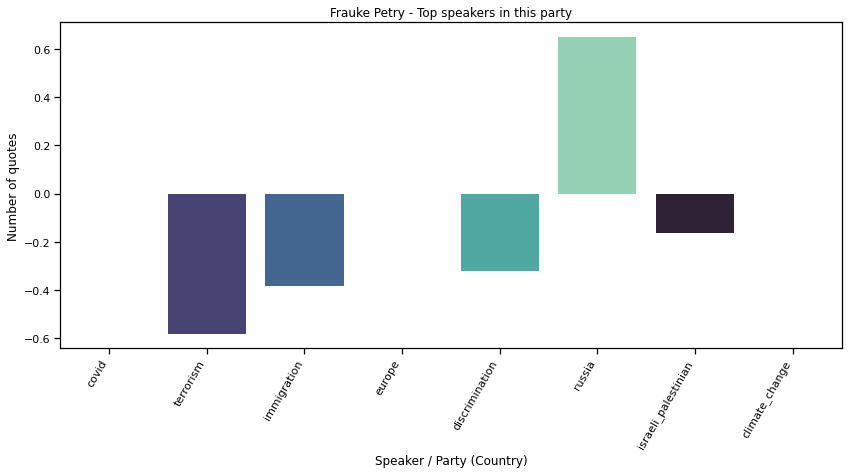

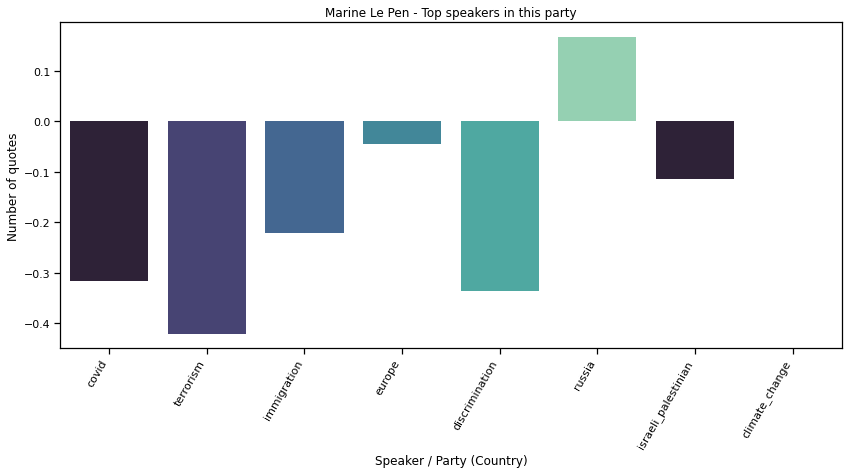

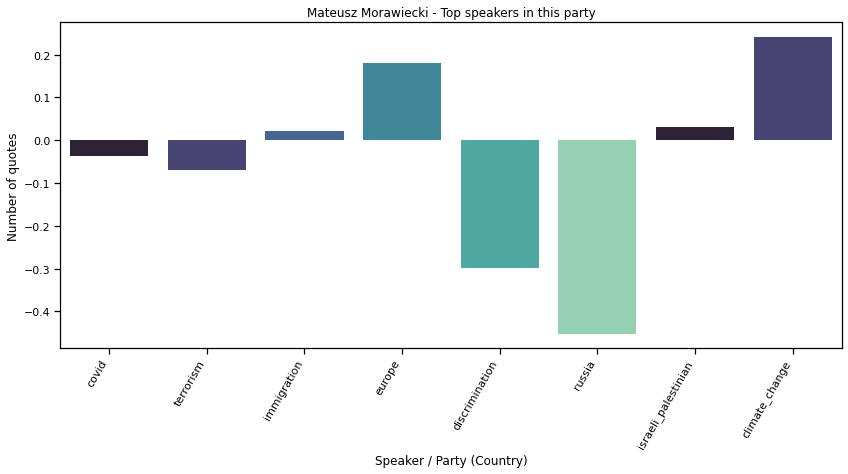

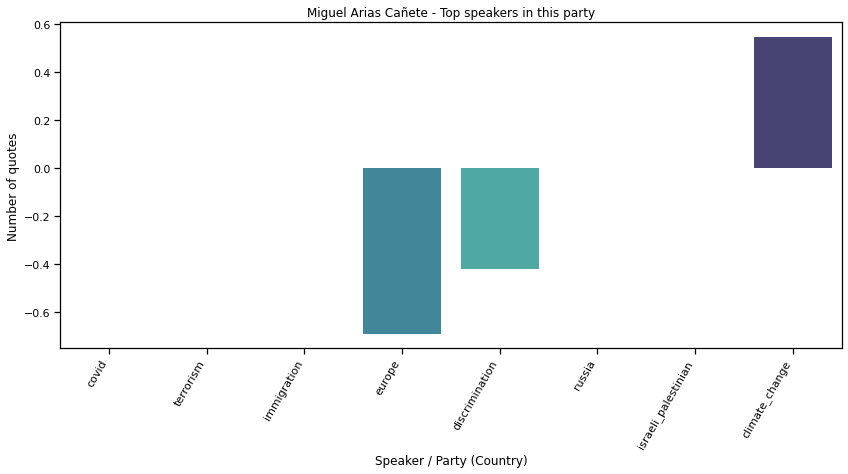

In [28]:
for politician in popular_politicians['speaker']:
    show_avg_polarity_of_speaker(politician, popular_politicians.fillna(0), topics)